<a href="https://colab.research.google.com/github/juanPellegrini11/Aprendizaje_por_refuerzos_taximetro/blob/main/Aprendizaje_por_refuerzos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Entrega 3 - Aprendizaje por refuerzo

Grupo 35:

    Juan Pellegrini       C.I.: 4.814.284-2
    Emiliano Hernández    C.I.: 4.660.612-3

# 1. Objetivo
El objetivo de esta tarea es implementar un algoritmo de aprendizaje por refuerzo para la simulación de la actividad de un taxi recorriendo una grilla donde, mediante una política eficiente, tiene que aprender a realizar movimientos, recoger a un pasajero en distintas ubicaciones y dejarlo en su destino correspondiente.
El agente (taxi) debe tomar decisiones para maximizar las recompensas a lo largo del recorrido, equilibrando la exploración de nuevas acciones con la explotación de acciones conocidas para lograr un rendimiento óptimo y penalizando comportamientos indeseados (como el dejar a un pasajero en un lugar incorrecto).




# 2. Implementación

Importamos la biblioteca Gymnassium, que vamos a usar como framework de RL

In [ ]:
!pip3 install cmake gymnasium scipy
import gymnasium as gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 12.6 MB/s eta 0:00:00


Creamos un ambiente y lo mostramos en pantalla. Para esto definimos una función para imprimir nuestro ambiente.

In [ ]:
# La semilla usada para crear el ambiente
semilla = 1

entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)

# Una funcion de ayuda para imprimir el estado de nuestro mundo
def print_env(estado):
  env_str = estado.render()
  print(env_str)

print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+





El rectángulo de color representa el taxi, amarillo cuando va sin pasajero y verde con pasajero.
'|' representa una pared que el taxi no puede cruzar, es decir.
R, G, Y, B son los puntos de interés, es decir, las posibles ubicaciones de recogida y destino. La letra azul representa la ubicación actual de recogida de pasajeros, y la letra púrpura es el destino actual.

Si cambiamos la semilla, cambia el estado del ambiente.

In [ ]:
# Una semilla diferente
semilla = 2

entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)

print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




Exploremos el espacio de estados y de acciones:

In [ ]:
print(f"Espacio de Acciones {entorno.action_space}")
print(f"Espacio de Estados {entorno.observation_space}")

Espacio de Acciones Discrete(6)
Espacio de Estados Discrete(500)


Hay 6 acciones, que corresponden a:
 * 0 = ir al Sur
 * 1 = ir al Norte
 * 2 = ir al Este
 * 3 = ir al Oeste
 * 4 = recoger pasajero
 * 5 = dejar pasajero

Los puntos cardinales siguen la convención Norte hacie arriba. Recoger/dejar al pasajero solo tienen efecto si el taxi está en la misma casilla que el pasajero, y en uno de los puntos de interés.

Nuestro agente deberá elegir la acción a tomar en cada paso. Gymnassium nos expone funciones para esto. Si queremos movernos al sur, por ejemplo:

In [ ]:
semilla = 1
entorno = gym.make("Taxi-v3", render_mode='ansi').env
entorno.reset(seed = semilla)
print_env(entorno)

accion = 0 # Sur
entorno.step(accion)

print_env(entorno)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)



Ahora estamos listos para programar un agente. Empezando por uno random. Se puede ejecutar el codigo abajo varias veces para ver como cambia en cada ejecución, debido a que la semilla_acciones es diferente.

In [ ]:
import random

def episodio_random(semilla_ambiente = 1):
    entorno = gym.make("Taxi-v3", render_mode='ansi').env
    entorno.reset(seed = semilla_ambiente)

    iteraciones = 0
    penalizaciones, recompensa = 0, 0

    marcos = [] # para la animación

    termino = False
    truncado = False

    while not termino and not truncado:
        #  selecciona una acción aleatoria del conjunto de todas las posibles acciones
        accion = entorno.action_space.sample()
        estado, recompensa, termino, truncado, info = entorno.step(accion)

        # El agente trato de dejar/recoger al pasajero incorrectamente
        if recompensa == -10:
            penalizaciones += 1

        # Put each rendered frame into dict for animation
        marcos.append({
            'marco': entorno.render(),
            'estado': estado,
            'accion': accion,
            'recompensa': recompensa
            }
        )

        iteraciones += 1


    print(f"Iteraciones: {iteraciones}")
    print(f"Penalizaciones: {penalizaciones}")

    return marcos

marcos = episodio_random()

Iteraciones: 839
Penalizaciones: 269


Podemos ver el episodio completo abajo. Notar que seleccionamos la semillia de selector de acciones para que la corrida sea 'buena'.

In [ ]:
from IPython.display import clear_output
from time import sleep
import sys

def print_frames(marcos):
    for i, marco in enumerate(marcos):
        clear_output()
        print(marco['marco'])
        print(f"Iteracion: {i + 1}")
        print(f"Estado: {marco['estado']}")
        print(f"Accion: {marco['accion']}")
        print(f"Recompensa: {marco['recompensa']}")
        sys.stdout.flush()
        # Aumentar este tiempo para ver mejor la animación
        sleep(.1)

print_frames(marcos)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Iteracion: 124
Estado: 0
Accion: 5
Recompensa: 20


Ahora queremos programar un agente inteligente, para eso nos vamos a atener a la siguiente interfaz.

In [ ]:
class Agente:
    def elegir_accion(self, estado, max_accion) -> int:
        """Elegir la accion a tomar en el estado actual y el espacio de acciones"""
        pass

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        """Aprender a partir de la tupla
            - estado_anterior: el estado desde que se empezó
            - estado_siguiente: el estado al que se llegó
            - accion: la acción que llevo al agente desde estado_anterior a estado_siguiente
            - recompensa: la recompensa recibida en la transicion
        """
        pass

Para nuestro agente aleatorio, esto sería:

In [ ]:
import random

class AgenteAleatorio(Agente):
    def elegir_accion(self, estado, max_accion) -> int:
        # Elige una acción al azar
        return random.randrange(max_accion)

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        # No aprende
        pass

Poniendolo a jugar:

In [ ]:
semilla = 1
entorno = gym.make("Taxi-v3", render_mode='ansi').env

agente = AgenteAleatorio()

iteraciones = 0
penalizaciones, recompensa = 0, 0

marcos = [] # for animation

termino = False
truncado = False
estado_anterior, info = entorno.reset(seed = semilla)
while not termino and not truncado:
    # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
    accion = agente.elegir_accion(estado_anterior, entorno.action_space.n)
    # Realizamos la accion
    estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
    # Le informamos al agente para que aprenda
    agente.aprender(estado_anterior, estado_siguiente, accion, recompensa)

    # El agente trato de dejar/recoger al pasajero incorrectamente
    if recompensa == -10:
        penalizaciones += 1

    # Put each rendered frame into dict for animation
    marcos.append({
        'marco': entorno.render(),
        'estado': estado_siguiente,
        'accion': accion,
        'recompensa': recompensa
        }
    )

    estado_anterior = estado_siguiente
    iteraciones += 1


print(f"Iteraciones: {iteraciones}")
print(f"Penalizaciones: {penalizaciones}")

Iteraciones: 2639
Penalizaciones: 838


Podemos encapsular lo anterior en una función

In [ ]:
def ejecutar_episodio(agente, semilla):
    entorno = gym.make("Taxi-v3", render_mode='ansi').env

    iteraciones = 0
    penalizaciones, recompensa, recompensa_acumulativa = 0, 0, 0

    marcos = [] # for animation

    termino = False
    truncado = False
    estado_anterior, info = entorno.reset(seed = semilla)
    while not termino and not truncado:
        # Le pedimos al agente que elija entre las posibles acciones (0..entorno.action_space.n)
        accion = agente.elegir_accion(estado_anterior, entorno.action_space.n)
        # Realizamos la accion
        estado_siguiente, recompensa, termino, truncado, info = entorno.step(accion)
        # Le informamos al agente para que aprenda
        agente.aprender(estado_anterior, estado_siguiente, accion, recompensa)

        # El agente trato de dejar/recoger al pasajero incorrectamente
        if recompensa == -10:
            penalizaciones += 1

        recompensa_acumulativa += recompensa
        # Put each rendered frame into dict for animation
        marcos.append({
            'marco': entorno.render(),
            'estado': estado_siguiente,
            'accion': accion,
            'recompensa': recompensa
            }
        )
        estado_anterior = estado_siguiente
        iteraciones += 1
    return iteraciones, recompensa_acumulativa

y correrlo varias veces para ver el rendimiento promedio

In [ ]:
agente = AgenteAleatorio()
semilla = 1
num_iteraciones_episodios = []
for i in range(10):
    num_iteraciones, recompensa_acumulativa = ejecutar_episodio(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]

Y obtener métricas al respecto

In [ ]:
import numpy
print(f"Se realizaron {numpy.mean(num_iteraciones_episodios)}, en promedio")

Se realizaron 3595.2, en promedio


La tarea a realizar consiste en programar un agente de aprendizaje por refuerzos:

Implementación del algoritmo

In [ ]:
class AgenteRL(Agente):
    def __init__(self, entorno, epsilon=0.5, gamma=0.9) -> None:
        super().__init__()
        self.entorno = entorno
        self.epsilon = epsilon  # Factor de exploración
        self.gamma = gamma      # Factor que prioriza recompensas inmediatas
        self.Tabla_Q = {}       # Se almacenan los valores Q
        self.q_values = []      # Se almacenan valores de Q promedio promediando el máximo q en cada estado para luego evaluar al agente

    def elegir_accion(self, estado, max_accion) -> int:
        if random.uniform(0, 1) < self.epsilon or estado not in self.Tabla_Q: # Si es la primera vez en este estado o random.uniform < epsilon
            #Hacemos "exploración"
            return random.randrange(max_accion)
        else:
            # Hacemos "explotación" (es decir, elegimos acción con valor máximo de Q si está en la Tabla_Q)
            return max(range(max_accion), key=lambda a: self.Tabla_Q[estado][a])

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        if estado_anterior not in self.Tabla_Q:
            #Inicializamos
            self.Tabla_Q[estado_anterior] = np.zeros(self.entorno.action_space.n)

        if estado_siguiente not in self.Tabla_Q:
            #Inicializamos
            self.Tabla_Q[estado_siguiente] = np.zeros(self.entorno.action_space.n)

        # Actualizamos valor de Q del estado anterior
        qanterior_actual = self.Tabla_Q[estado_anterior][accion]
        mejor_qsiguiente = np.max(self.Tabla_Q[estado_siguiente])
        nuevo_qanterior = recompensa + self.gamma * mejor_qsiguiente
        self.Tabla_Q[estado_anterior][accion] = nuevo_qanterior
        #Actualizamos valor de Q promedio
        q_average = np.mean([np.max(q_values) for q_values in self.Tabla_Q.values()])
        self.q_values.append(q_average)
        return self.q_values

Y ejecutar con el muchos episodios con la misma semilla:

In [ ]:
import numpy as np
agente = AgenteRL(entorno)
semilla = 1
num_iteraciones_episodios = []
q_promedio = []
recompensa_acumulada_promedio = []
for i in range(1000):
    num_iteraciones, recompensas = ejecutar_episodio(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]
    # Se agrega esta variable para evaluar que tan bien aumenta la recompensa acumulada de cada acción
    if not recompensa_acumulada_promedio:
      recompensa_acumulada_promedio += [recompensas]
    else:
      recompensa_acumulada_promedio += [(recompensas + recompensa_acumulada_promedio[i-1])/(i+1)]
    q_promedio.append(np.mean(agente.q_values))

# Analizar los resultados de la ejecución anterior.

Consideraciones del algoritmo desarrollado:

*  A partir de un estado inicial (taxi en un lugar determinado y pasajero esperando en un lugar específico y con destino definido) existen uno o más caminos los cuales son los más eficientes para completar el recorrido. Estos no cambian en el transcurso de la ejecución de la tarea por lo que los mismos están definidos por las condiciones iniciales, lo cual demanda que se utilice un enfoque determinista, por lo que se aplica esta condición en el algoritmo utilizado.
*  Para decidir si realizar una tarea de exploración o explotación el AgenteRL utiliza un valor de epsilon fijo. Se elije un valor aleatorio entre 0 y 1 y si el mismo es menor que epsilon entonces se explora. Para esta etapa se selecciona un epsilon de valor = 0.5 para que apróximadamente realice las mismas veces acciones de explotación y exploración.
*  Para evaluar el algoritmo se decide guardar el promedio de los valores de q máximos. Esto se realiza obteniendo el valor de q máximo para cada escenario que el algoritmo utiliza y promediándolos. Este valor se utiliza como métrica luego para ver como evoluciona al ejecutar distintos episodios.
*  Se decide modificar la función ejecutar_episodio para poder obtener una métrica de la recompensa acumulada que obtiene el algoritmo cada vez que se ejecuta. Con este cambio la función retorna una tupla con la cantidad de iteraciones y la suma de las recompensas que se obtiene.
Esto se utiliza para generar la métrica "recompensa_acumulada_promedio" la cual agrega en una lista el promedio acumulado a partir de las recompensas obtenidas en los episodios anteriores. Con esta métrica se espera que a medida que se ejecuten distintos episodios y el algoritmo aprenda, el promedio de recompensas aumente y luego se mantenga apróximadamente constante (cuando deje de aprender).


Definición de funciones para graficar resultados:

In [ ]:
def graficar_iteraciones(num_iteraciones_episodios, subtitulo_grafico):
  # Crear la gráfica de dispersión
  plt.figure(figsize=(8, 4))
  plt.scatter(range(1, len(num_iteraciones_episodios) + 1), num_iteraciones_episodios, marker='.', color='b', label='Iteraciones')
  plt.xlabel('Episodio')
  plt.ylabel('Iteraciones')
  plt.title(f'Número de iteraciones por episodio para {subtitulo_grafico}')
  plt.show()

def graficar_Q_promedios(q_promedio):
  # Graficamos los valores de Q promedio
  plt.figure(figsize=(8, 4))
  plt.scatter(range(len(q_promedio)), q_promedio, marker='.', color='orange')
  plt.xlabel('Episodio')
  plt.ylabel('Q Promedio')
  plt.title('Valor de Q Promedio a lo largo de los Episodios')
  plt.show()

def graficar_recompensa_acumulada(recompensa_acumulada, episodio_inicio):
  # Graficamos los valores de recompensa acumulada
  plt.figure(figsize=(8, 4))
  plt.scatter(range(episodio_inicio, len(recompensa_acumulada)), recompensa_acumulada[episodio_inicio:], marker='.', color='g')
  plt.xlabel('Episodio')
  plt.ylabel('Recompensa acumulada')
  plt.title('Valor de recompensa acumulada a lo largo de los Episodios')
  plt.show()

In [ ]:
import matplotlib.pyplot as plt
print(f"Se realizaron {numpy.mean(num_iteraciones_episodios)}, en promedio")
print(f'El promedio de recompensas acumuladas fue de: {numpy.mean(recompensa_acumulada_promedio)}')

Se realizaron 31.113, en promedio
El promedio de recompensas acumuladas fue de: -7.356729606602114


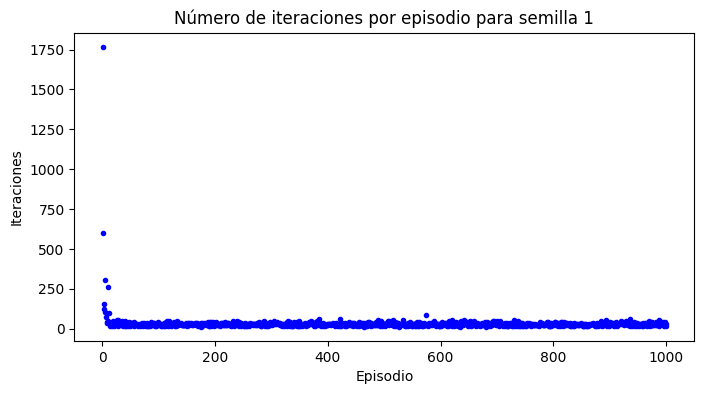

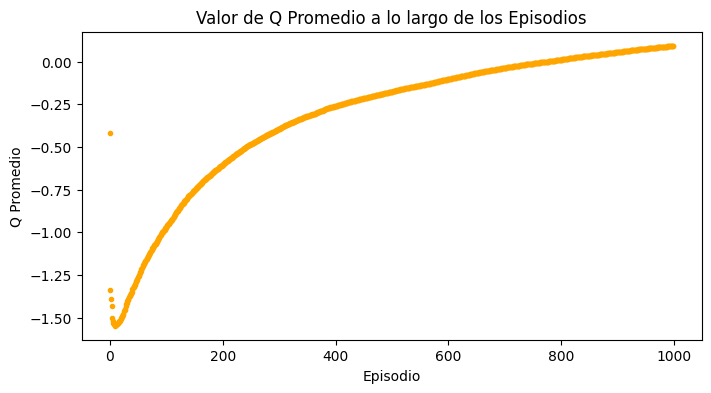

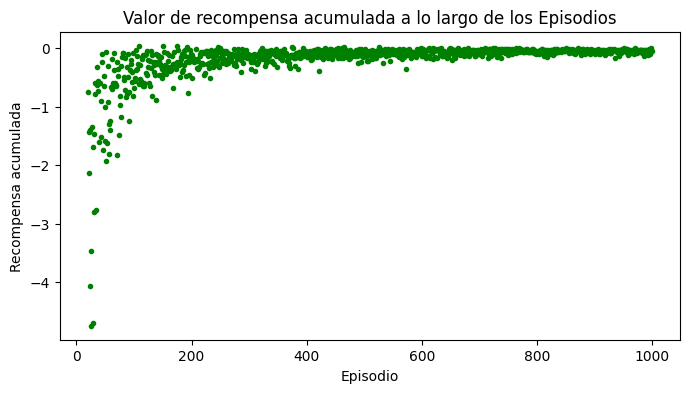

In [ ]:
graficar_iteraciones(num_iteraciones_episodios, f'semilla {semilla}')
graficar_Q_promedios(q_promedio)
graficar_recompensa_acumulada(recompensa_acumulada_promedio, 20)

Como se puede ver en la gráfica de iteraciones por episodio, el agente aprende muy rápidamente la política que maximiza las recompensas, por eso es que después de unos pocos episodios el número de iteraciones baja hasta un valor apróximadamente constante. Este valor al que tiende no es constante ya que al realizar aleatoriamente una cierta cantidad de exploraciones el valor de iteraciones en cada episodio se ve afectado por este factor aleatorio.
Si vemos la gráfica de Q promedio (el Q promedio es el valor promedio de los valores máximos de la tabla Q para cada escenario), se puede ver que el mismo aumenta con el correr de los episodios lo cual es señal de que el algoritmo está aprendiendo y mejorando su rendimiento ya que encuentra a una (o más) acciones dentro de las seis posibles como las más eficientes y, a medida que continúa aprendiendo con un mismo escenario inicial, mejora el puntaje de la las mismas.
Esto también se puede ver al evaluar el parámetro de recompensa acumulada, donde se ve que en el transcurso de cada episodio la misma aumenta y se acerca a un valor constante.

Otra particularidad a comentar de la gráfica del valor promedio de los máximos valores de la tabla Q para cada escenario es que al principio tiene una fuerte bajada, esto se da porque en un comienzo los valores de la tabla Q están inicializados con ceros, en las primeras iteraciones empeora el valor por esto pero luego aumenta debido al aprendizaje.

# Se mantiene el rendimiento si cambiamos la semilla? Por qué?


Resultados para semilla 2
Se realizaron 43.8, en promedio
El promedio de recompensas acumuladas fue de: -41.302805011183715



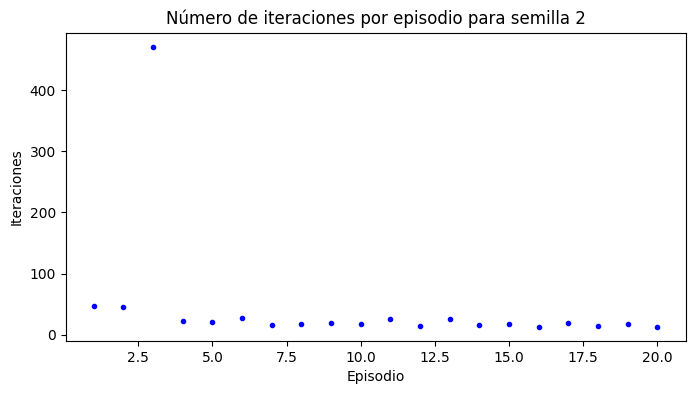

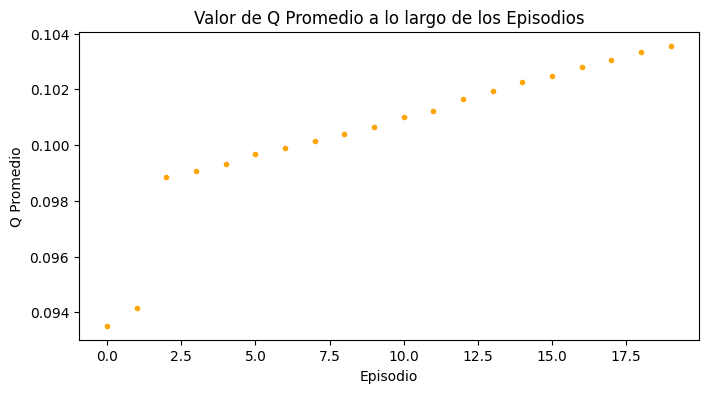

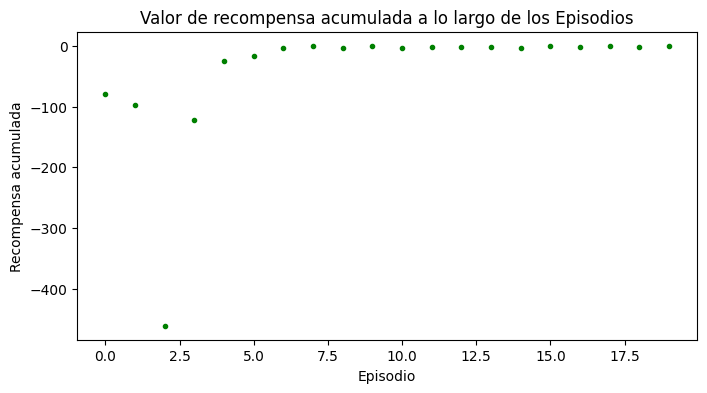


Resultados para semilla 27
Se realizaron 86.7, en promedio
El promedio de recompensas acumuladas fue de: -134.78425553247257



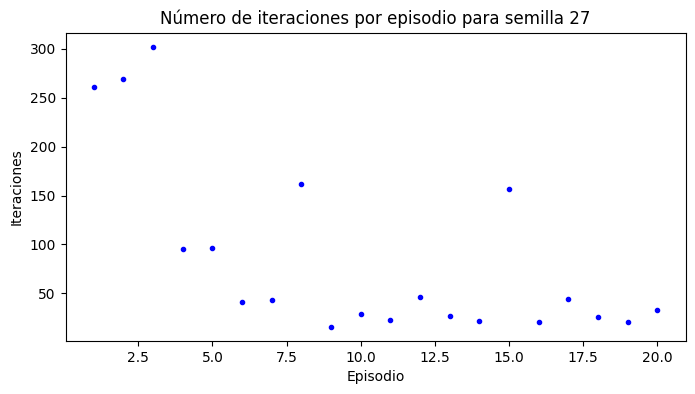

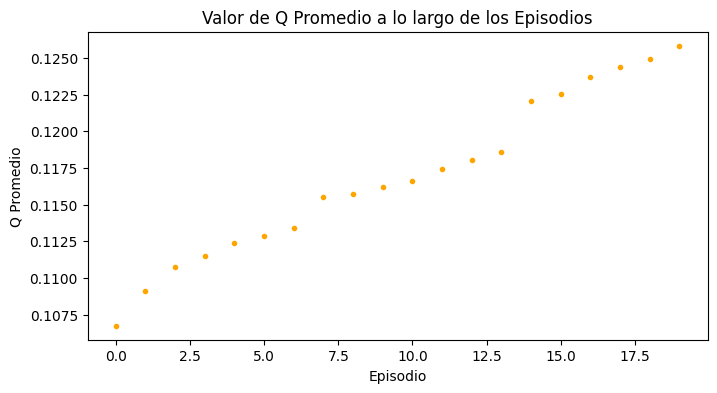

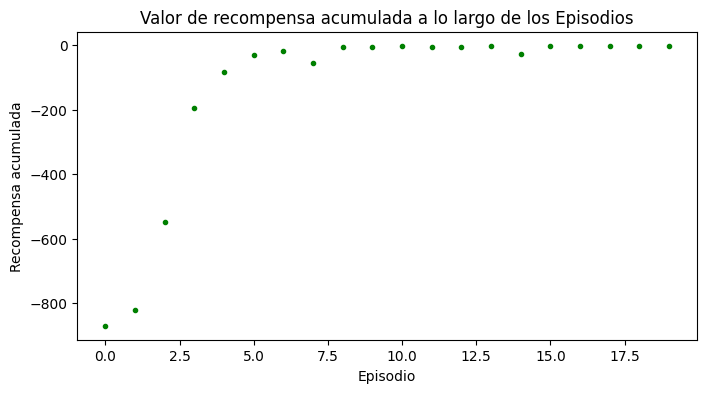

In [ ]:
semilla = 2
num_iteraciones_episodios = []
q_promedio = []
recompensa_acumulada_promedio = []
for i in range(20):
    num_iteraciones, recompensas = ejecutar_episodio(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]
    # Se agrega esta variable para evaluar que tan bien aumenta la recompensa acumulada de cada acción
    if not recompensa_acumulada_promedio:
      recompensa_acumulada_promedio += [recompensas]
    else:
      recompensa_acumulada_promedio += [(recompensas + recompensa_acumulada_promedio[i-1])/(i+1)]
    q_promedio.append(np.mean(agente.q_values))

print('')
print(f'Resultados para semilla {semilla}')
print(f"Se realizaron {numpy.mean(num_iteraciones_episodios)}, en promedio")
print(f'El promedio de recompensas acumuladas fue de: {numpy.mean(recompensa_acumulada_promedio)}')
print('')
#Creamos gráficas de iteraciones por episodio
graficar_iteraciones(num_iteraciones_episodios, f'semilla {semilla}')
graficar_Q_promedios(q_promedio)
graficar_recompensa_acumulada(recompensa_acumulada_promedio, 0)

semilla = 27
num_iteraciones_episodios = []
q_promedio = []
recompensa_acumulada_promedio = []
for i in range(20):
    num_iteraciones, recompensas = ejecutar_episodio(agente, semilla)
    num_iteraciones_episodios += [num_iteraciones]
    # Se agrega esta variable para evaluar que tan bien aumenta la recompensa acumulada de cada acción
    if not recompensa_acumulada_promedio:
      recompensa_acumulada_promedio += [recompensas]
    else:
      recompensa_acumulada_promedio += [(recompensas + recompensa_acumulada_promedio[i-1])/(i+1)]
    q_promedio.append(np.mean(agente.q_values))

print('')
print(f'Resultados para semilla {semilla}')
print(f"Se realizaron {numpy.mean(num_iteraciones_episodios)}, en promedio")
print(f'El promedio de recompensas acumuladas fue de: {numpy.mean(recompensa_acumulada_promedio)}')
print('')
#Creamos gráficas de iteraciones por episodio
graficar_iteraciones(num_iteraciones_episodios, f'semilla {semilla}')
graficar_Q_promedios(q_promedio)
graficar_recompensa_acumulada(recompensa_acumulada_promedio, 0)

Como podemos ver, el desempeño del agente al cambiar de semilla (usando la semilla 1) en la primer iteración es mucho mayor al rendimiento de un agente random. Sin embargo, al entrenar al agente para una semilla dada y luego usarlo con otra semilla se obtienen resultados bastante inferiores a los previos.

Esto es de esperarse pues el agente no tiene información en la Tabla Q sobre estas nuevas condiciones del entorno. Al cambiar de semilla pueden cambiar: la posición inicial del agente, el punto donde recoge y a donde lleva al pasajero. Esto genera que las acciones que tenga que ejecutar para cumplir su cometido (y maximizar las recompensas) sean distintas para cada semilla y tenga que aprender para cada semilla la mejor secuencia de acciones. Es decir, debe completar la tabla Q para todos los escenarios posibles dentro del conjunto de posibilidades del ambiente.

Otro caso interesante es al entrenar al agente con la semilla 27. Vemos que presenta un número de iteraciones muy superior al primero con la semilla 2. Esto puede explicarse por que el escenario de partida de la semilla 27 es más diferente que el escenario de partida de la semilla 1 de lo que lo es el de la semilla 2 respecto a la semilla 1: la semilla 1 y la semilla 2 comparten el mismo destino de pasajero, mientras que la semilas 27 no comparte nada con la 1.

Aclaración: no se evaluó el agente con


#Podemos mejorar el agente para que se desempeñe bien usando cualquier semilla?

La respuesta a esta pregunta es si. Para esto, es necesario entrenar al agente con una cierta cantidad de semillas al azar diferentes, esperando que en ese grupo de semillas al azar haya una semilla representante de cada uno de los distintos estados iniciales posibles "principales". Con principales, nos referimos a un conjunto de 12 semillas: tres por cada punto en el que el taxi tiene que recoger al pasajero (por ejemplo, si lo recoge en el punto R, debemos considerar 3 semillas, una por cada posible punto de destino ("Y", "G" y "B")) y por ser cuatro los puntos posibles nos queda 3x4 semillas "principales".
Entrenando al agente con estas semillas y mediante el uso adecuado de la explotación/exploración se puede obtener buenos resultados para cualquier semilla diferente.

Otra posible implementación que puede ayudar a diminuir el número de pasos del agente es cambiar la premisa para que el agente haga exploración/explotación. Para esto, en lugar de utilizar un valor de epsilon fijo y luego a partir de él aleatoriamente decidir que hacer, podemos hacerlo a partir del siguiente cociente:



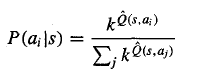



En este enfoque probabilístico cuando una acción tiene un Q alto podemos decir que tiene más probabilidad. Si la acción más probable tiene una probabilidad mayor a cierto valor, el agente hará explotación. La idea de este enfoque es que en la medida que el agente aprende disminuirá la cantidad de iteraciones en las que se dedica a explorar, mejorando de esta manera el rendimiento del mismo. En definitiva, con esto podemos equilibrar la exploración/explotación a lo largo del entrenamiento, con mayor exploración al principio y menos al final. En caso de que la probabilidad de una acción sea mayor que una constante que llamaremos "epsilon", se realizará explotación.

Se hicieron pruebas con distintos valores de "epsilon". Se ajusto este hiperparámetro y se compararon las iteraciones promedio con las nuevas semillas para elegir que valor tomar. Se compararon los siguientes valores de epsilon: 0.05, 0.2, 0.4, 0.6, 0.8 y 0.95. Aquí se encontró que la menor cantidad de iteraciones promedio se obtuvo para el valor 0.05. Este fue el valor que se utilizó para la obtención de los resultados finales. Se eligió este valor porque fue el que con las semillas nuevas, es decir con las semillas que el modelo no estaba entrenado, llegó al destino en el menor número promedio de iteraciones. Tanto el valor 0.05 como el 0.4 obtuvieron un número similar de iteraciones promedio (el valor 0.05 obtuvo 23 contra 27 del 0.4) y cualquiera de los dos valores podrían usarse para el "agente definitivo". Sin embargo, se observa que con un epsilon 0.05 llega a un ratio exploración/explotación promedio de 0.12 mientras que con epsilon 0.4 llega a un valor 0.26 (es decir, que en promedio el agente explora en 12 de cada 100 y en 26 de cada 100 iteraciones, respectivamente) los cuales son valores bastante altos. Por esta razón puede parecer más atractivo un agente que no explore tanto, y posiblemente por esta tasa de exploración tan alta es que tiene una performance un poco peor con epsilon = 0.4.

A continuación se muestran las pruebas realizadas para elegir el epsilon:

Se realizaron 23.483333333333334, en promedio


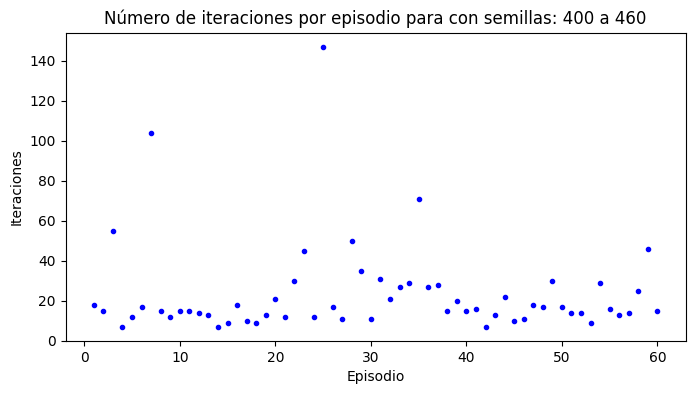

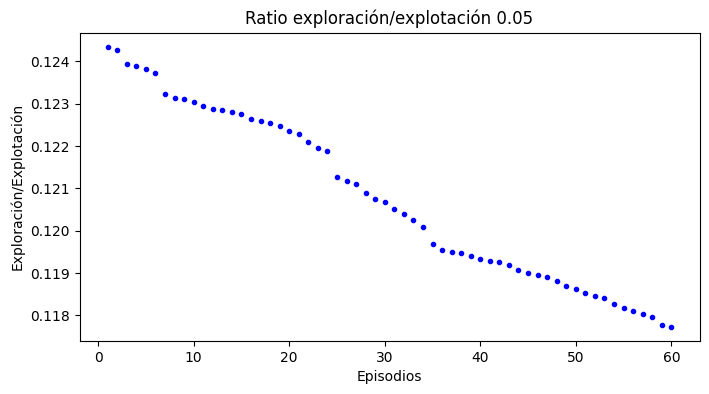

Se realizaron 30.116666666666667, en promedio


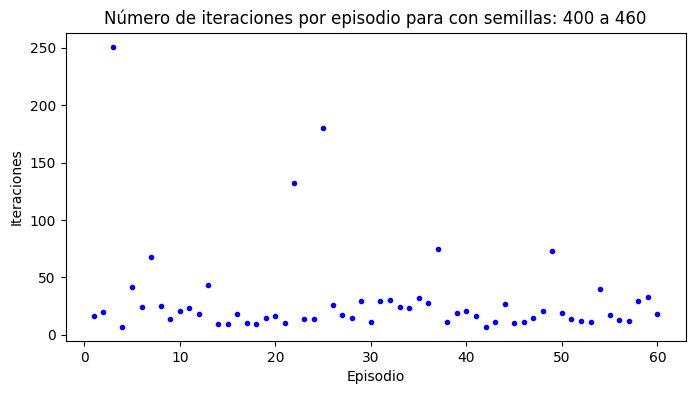

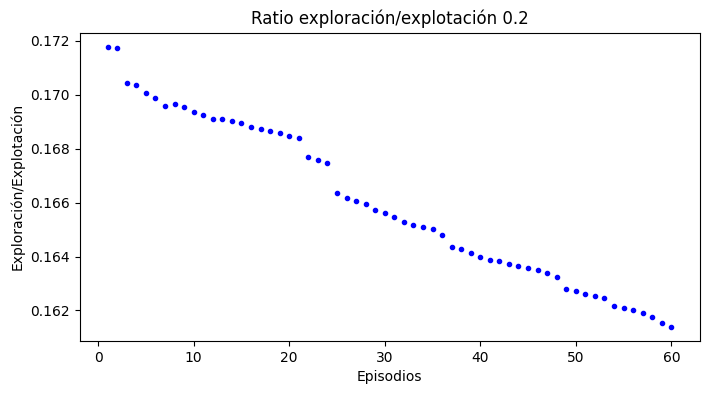

Se realizaron 27.066666666666666, en promedio


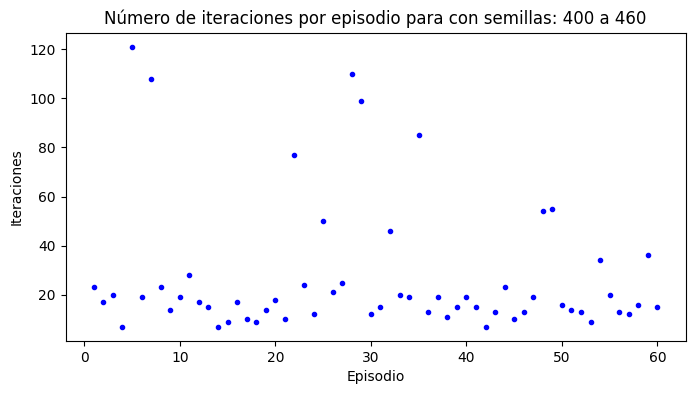

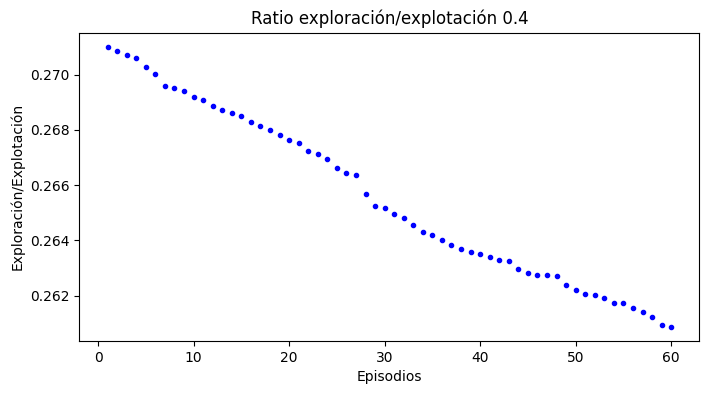

Se realizaron 29.383333333333333, en promedio


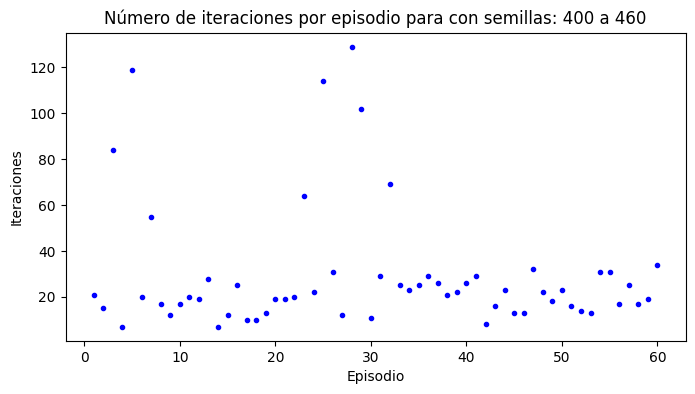

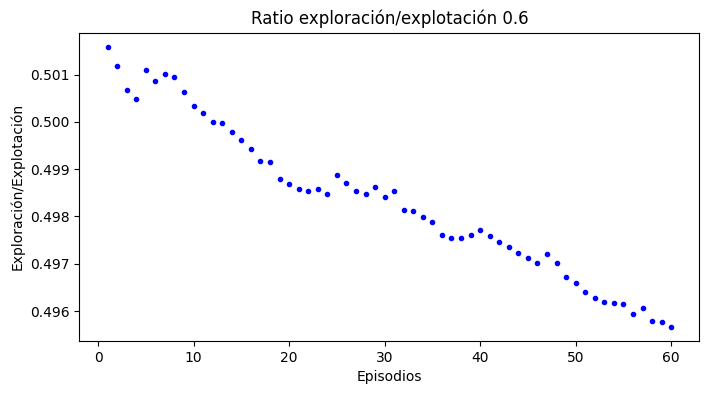

Se realizaron 41.483333333333334, en promedio


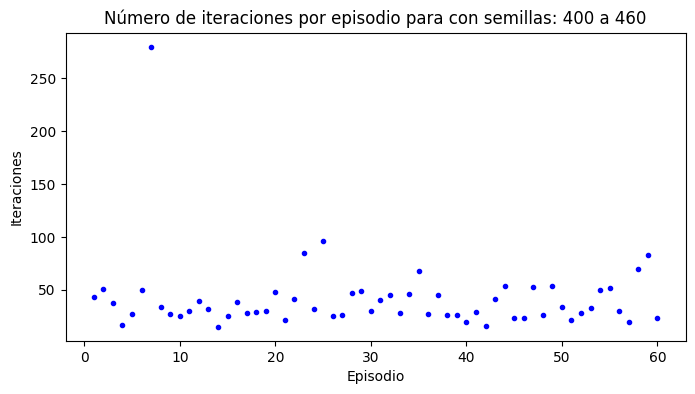

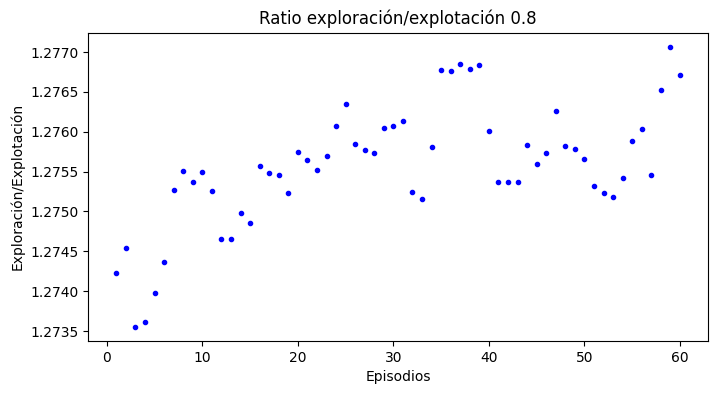

Se realizaron 86.5, en promedio


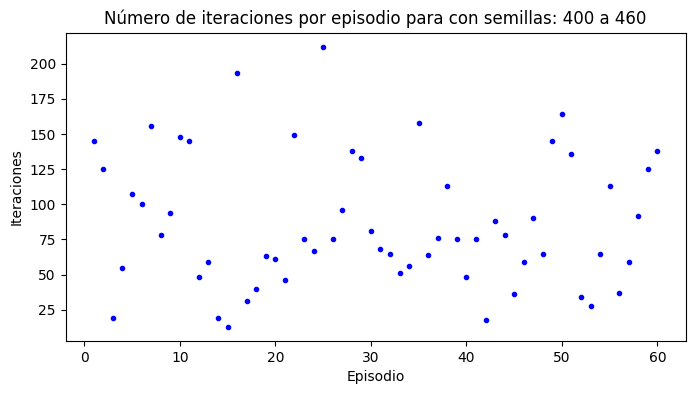

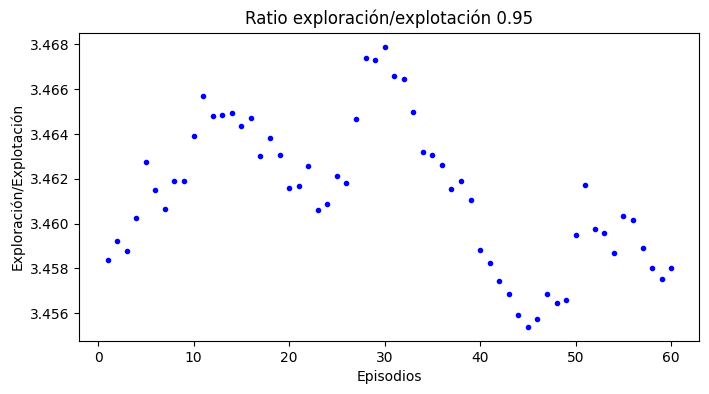

In [ ]:
def pruebaepsilon(k):
    import numpy as np

    class Agentedefinitivo(Agente):
        def __init__(self, entorno, epsilon=k, gamma=0.9) -> None:
            super().__init__()
            self.entorno = entorno
            self.epsilon = epsilon  # Factor de exploración
            self.gamma = gamma      # Factor que prioriza recompensas inmediatas
            self.Tabla_Q = {}       # Acá almacenamos los valores Q
            self.q_values = []      # Acá almacenamos valores de Q promedio para evaluar al agente
            self.explor = 0.001        # Acá almacenamos exploracion
            self.explot = 0.001        # Acá almacenamos explotacion
            self.exploratio = []        # Acá almacenamos ratio exploracion explotacion del agente

        def elegir_accion(self, estado, max_accion) -> int:
            if estado not in self.Tabla_Q:
              # Hacemos "exploración"
              return random.randrange(max_accion)
            else:
              suma_acciones = 0
              probabilidades_acciones = []
              for accion in self.Tabla_Q[estado]:
                suma_acciones += self.epsilon**accion
              for accion in self.Tabla_Q[estado]:
                probabilidades_acciones += [(self.epsilon**accion)/suma_acciones]
              if max(probabilidades_acciones) < random.uniform(0, 1): #Entonces elegimos acción al azar
                  # Hacemos "exploración"
                  self.explor += 1
                  self.exploratio.append(self.explor/self.explot)
                  return random.randrange(max_accion)
                  return self.exploratio
              else:
                  # Hacemos "explotación" (es decir, elegimos acción con valor máximo de Q si está en la Tabla_Q)
                  self.explot += 1
                  self.exploratio.append(self.explor/self.explot)
                  return max(range(max_accion), key=lambda a: self.Tabla_Q[estado][a])
                  return self.exploratio


        def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
            if estado_anterior not in self.Tabla_Q:
                #Inicializamos
                self.Tabla_Q[estado_anterior] = np.zeros(self.entorno.action_space.n)

            if estado_siguiente not in self.Tabla_Q:
                #Inicializamos
                self.Tabla_Q[estado_siguiente] = np.zeros(self.entorno.action_space.n)

            # Actualizamos valor de Q del estado anterior
            qanterior_actual = self.Tabla_Q[estado_anterior][accion]
            mejor_qsiguiente = np.max(self.Tabla_Q[estado_siguiente])
            nuevo_qanterior = recompensa + self.gamma * mejor_qsiguiente
            self.Tabla_Q[estado_anterior][accion] = nuevo_qanterior
            #Actualizamos valor de Q promedio
            q_average = np.mean([np.max(q_values) for q_values in self.Tabla_Q.values()])
            self.q_values.append(q_average)
            return self.q_values
            return self.exploratio

    agente = Agentedefinitivo(entorno)
    #Me defino un conjunto de semillas que previamente me aseguré de que hubiese al menos una de las "12 tipos de semillas principales"
    semillas = [1,2,3,6,7,10,12,16,18,20,23,48]
    num_iteraciones_episodios = []
    q_promedio = []
    exploratio = []
    for j in semillas:
      for i in range(50):
          num_iteraciones,recompensas = ejecutar_episodio(agente, j)
          num_iteraciones_episodios += [num_iteraciones]
          q_promedio.append(np.mean(agente.q_values))
          exploratio.append(agente.exploratio[-1])

    semillas = list(range(400,460))
    num_iteraciones_episodios = []
    q_promedio = []
    exploratio = []
    for i in semillas:
        num_iteraciones,recompensas = ejecutar_episodio(agente, i)
        num_iteraciones_episodios += [num_iteraciones]
        q_promedio.append(np.mean(agente.q_values))
        exploratio.append(agente.exploratio[-1])

    print(f"Se realizaron {numpy.mean(num_iteraciones_episodios)}, en promedio")
    #Creamos gráficas de iteraciones por episodio
    graficar_iteraciones(num_iteraciones_episodios, 'semillas de: 400 a 460')

    plt.figure(figsize=(8, 4))
    plt.scatter(range(1, len(exploratio) + 1), exploratio, marker='.', color='b')
    plt.xlabel('Episodios')
    plt.ylabel('Exploración/Explotación')
    plt.title(f'Ratio exploración/explotación {k}')
    plt.show()

for k in [0.05,0.2,0.4,0.6,0.8,0.95]:
    pruebaepsilon(k)

A continuación se entrena al agente con el valor de epsilon elegido (0.2) y se prueba con semillas diferentes:

In [ ]:
class Agentedefinitivo(Agente):
    def __init__(self, entorno, epsilon=0.05, gamma=0.9) -> None:
        super().__init__()
        self.entorno = entorno
        self.epsilon = epsilon  # Factor de exploración
        self.gamma = gamma      # Factor que prioriza recompensas inmediatas
        self.Tabla_Q = {}       # Se almacenan los valores Q
        self.q_values = []      # Se almacenan valores de Q promedio promediando el máximo q en cada estado para luego evaluar al agente

    def elegir_accion(self, estado, max_accion) -> int:
        if estado not in self.Tabla_Q:
          # Hacemos "exploración"
          return random.randrange(max_accion)
        else:
          suma_acciones = 0
          probabilidades_acciones = []
          for accion in self.Tabla_Q[estado]:
            suma_acciones += self.epsilon**accion
          for accion in self.Tabla_Q[estado]:
            probabilidades_acciones += [(self.epsilon**accion)/suma_acciones]
          if max(probabilidades_acciones) < random.uniform(0, 1): #Entonces elegimos acción al azar
              # Hacemos "exploración"
              return random.randrange(max_accion)
          else:
            # Hacemos "explotación" (es decir, elegimos acción con valor máximo de Q si está en la Tabla_Q)
            return max(range(max_accion), key=lambda a: self.Tabla_Q[estado][a])

    def aprender(self, estado_anterior, estado_siguiente, accion, recompensa):
        if estado_anterior not in self.Tabla_Q:
            #Inicializamos
            self.Tabla_Q[estado_anterior] = np.zeros(self.entorno.action_space.n)

        if estado_siguiente not in self.Tabla_Q:
            #Inicializamos
            self.Tabla_Q[estado_siguiente] = np.zeros(self.entorno.action_space.n)

        # Actualizamos valor de Q del estado anterior
        qanterior_actual = self.Tabla_Q[estado_anterior][accion]
        mejor_qsiguiente = np.max(self.Tabla_Q[estado_siguiente])
        nuevo_qanterior = (recompensa + self.gamma * mejor_qsiguiente)
        self.Tabla_Q[estado_anterior][accion] = nuevo_qanterior
        #Actualizamos valor de Q promedio
        q_average = np.mean([np.max(q_values) for q_values in self.Tabla_Q.values()])
        self.q_values.append(q_average)
        return self.q_values


Resultados para las 12 semillas elegidas
Se realizaron 39.08833333333333, en promedio
El promedio de recompensas acumuladas fue de: -87.50513326450925



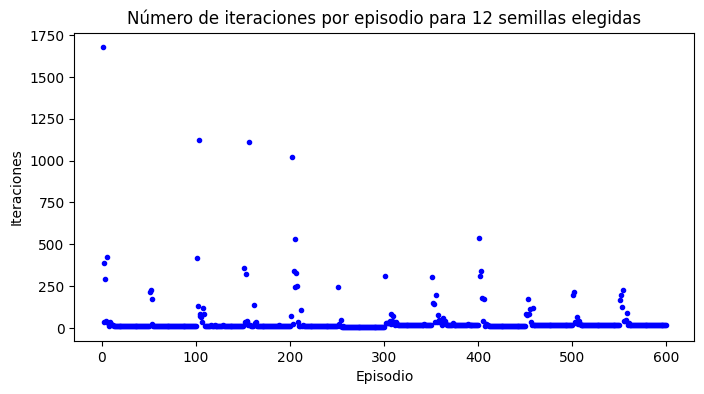

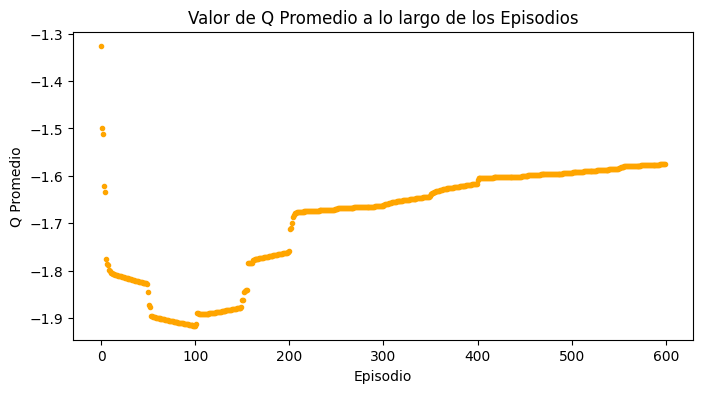

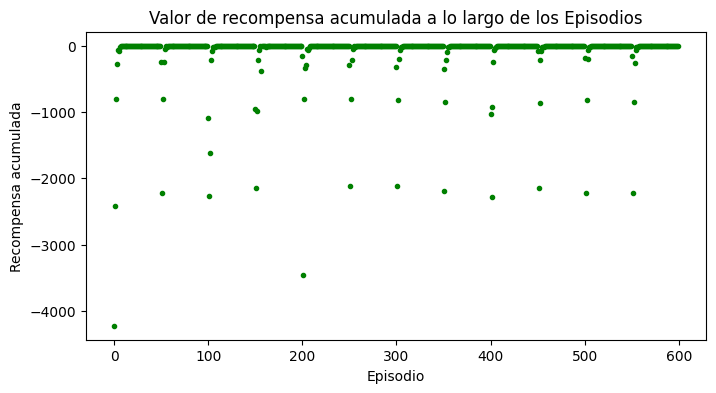


Resultados con semillas desde 60 a 460
Se realizaron 16.985, en promedio
El promedio de recompensas acumuladas fue de: -0.15266535367730827



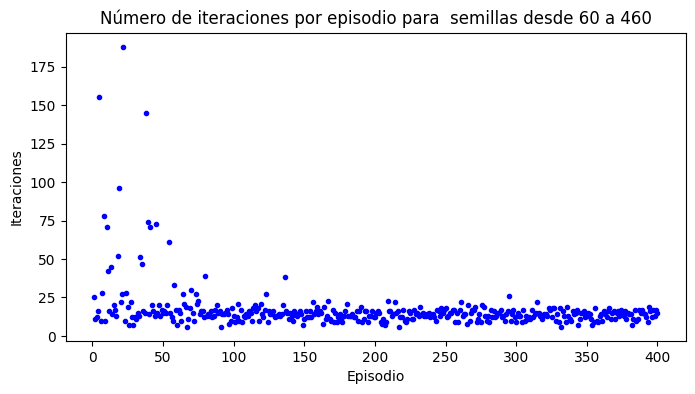

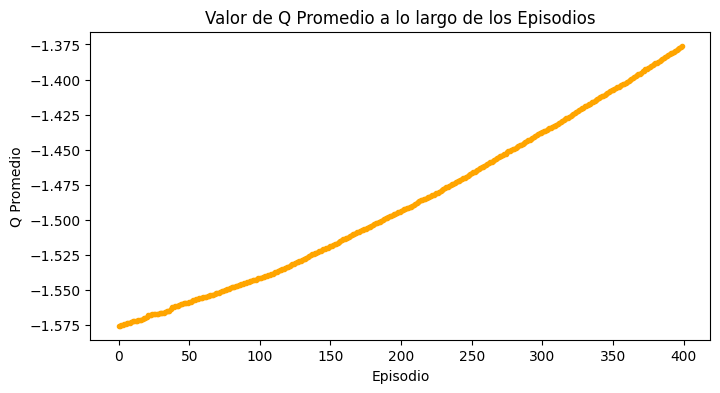

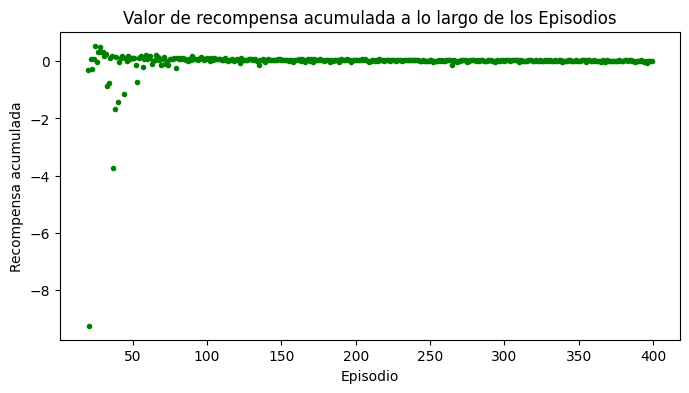

In [ ]:
agente = Agentedefinitivo(entorno)
#Defino un conjunto de semillas que previamente se investiga que tengan al menos una de los "12 tipos de semillas principales"
semillas = [1,2,3,6,7,10,12,16,18,20,23,48]
num_iteraciones_episodios = []
q_promedio = []
recompensa_acumulada_promedio = []
for semilla in semillas:
  for i in range(50):
      num_iteraciones, recompensas = ejecutar_episodio(agente, semilla)
      num_iteraciones_episodios += [num_iteraciones]
      # Se agrega esta variable para evaluar que tan bien aumenta la recompensa acumulada de cada acción
      if not recompensa_acumulada_promedio:
        recompensa_acumulada_promedio += [recompensas]
      else:
        recompensa_acumulada_promedio += [(recompensas + recompensa_acumulada_promedio[i-1])/(i+1)]
      q_promedio.append(np.mean(agente.q_values))

print('')
print(f'Resultados para las 12 semillas elegidas')
print(f"Se realizaron {numpy.mean(num_iteraciones_episodios)}, en promedio")
print(f'El promedio de recompensas acumuladas fue de: {numpy.mean(recompensa_acumulada_promedio)}')
print('')
#Creamos gráficas de iteraciones por episodio
graficar_iteraciones(num_iteraciones_episodios, f'12 semillas elegidas')
graficar_Q_promedios(q_promedio)
graficar_recompensa_acumulada(recompensa_acumulada_promedio, 0)

semillas = list(range(60,460))
num_iteraciones_episodios = []
q_promedio = []
recompensa_acumulada_promedio = []
for i in semillas:
    num_iteraciones, recompensas = ejecutar_episodio(agente, i)
    num_iteraciones_episodios += [num_iteraciones]
    # Se agrega esta variable para evaluar que tan bien aumenta la recompensa acumulada de cada acción
    if not recompensa_acumulada_promedio:
      recompensa_acumulada_promedio += [recompensas]
    else:
      recompensa_acumulada_promedio += [(recompensas + recompensa_acumulada_promedio[i-61])/(i-59)]
    q_promedio.append(np.mean(agente.q_values))

print('')
print(f'Resultados con semillas desde 60 a 460')
print(f"Se realizaron {numpy.mean(num_iteraciones_episodios)}, en promedio")
print(f'El promedio de recompensas acumuladas fue de: {numpy.mean(recompensa_acumulada_promedio)}')
print('')
#Creamos gráficas de iteraciones por episodio
graficar_iteraciones(num_iteraciones_episodios, ' semillas desde 60 a 460')
graficar_Q_promedios(q_promedio)
graficar_recompensa_acumulada(recompensa_acumulada_promedio, 20)

#Conclusiones finales

Como se puede comprobar, al entrenar al agente con al menos un caso de las "12 semillas principales" tiene un desempeño bastante bueno en general al ser testeado con otras semillas.

Esto puede verse en que luego del entrenamiento con las 12 semillas elegidas (50 episodios con cada semilla), en ningun caso el agente pasa las 175 iteraciones con nuevas semillas, mientras que en el entrenamiento en 600 escenarios tuvo descenas de escenarios con más de 200 iteraciones y 3 escenarios con más de mil iteraciones.

Al ser puesto a prueba con las semillas 60 a 460 el agente sigue aprendiendo. Luego de evaluar al agente con las primeras 30 semillas (1 episodio por semilla) el agente queda por debajo de las 75 episodios(porque sigue aprendiendo). Aún sigue siendo una performance no muy buena pero si se lo compara con el agente random o con el agente que solo se entrenaba con una semilla hay una diferencia muy grande (de más de mil iteraciones). Y luego de ser evalauado con las primeras 200 de las 400 semillas el agente logra que para toda semilla nuevas los episodios queden por debajo de las 25 iteraciones.

Viendo las gráficas del valor de recompensa o de valor de Q promedio vemos que al entrenar (con las "12 semillas principales" estos valores tienden rapidamente a un valor constante, lo que sugiere que el agente aprende muy rapidamente. Por esto, en lugar de entrenarse con 50 episodios con cada una de las "12 semillas principales" podríamos entrenarlo con 10 episodios con esas 12 semillas y obtendremos una performance similar. Y si queremos que el agente de mejores resultados con el menor entrenamiento posible podemos entrenarlo con más semillas (10 episodios por semilla parece ser suficiente a partir de la gráfica de recompensas acumuladas promedio).